# Basic setting

In [6]:
import torch
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras_preprocessing.sequence import pad_sequences

from plot import plot_seaborn, plot_box
from interface import newModel, genData, load_params, read_sequence, aa_dict, caculate_metric
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
import torch.nn.functional as F

In [2]:
import os
path = './figure/length_importance/'
if os.path.exists(path) is False:
    os.makedirs(path)

In [3]:
plt.rcParams['savefig.dpi'] = 500  # 图片像素
plt.rcParams['figure.dpi'] = 500  # 分辨率

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
device = torch.device("cuda", 0)
aa_dict = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5, 'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10,
           'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15, 'O': 16, 'S': 17, 'U': 18, 'T': 19,
           'W': 20, 'Y': 21, 'V': 22, 'X': 23}

positive_sequences, negative_sequences = read_sequence('./SSP_dataset.csv')

In [5]:
def genData(pep):
    pep_codes = []
    for aa in pep:
        pep_codes.append(aa_dict[aa])

    pep_codes = pad_sequences([pep_codes], maxlen=299, padding='post', dtype=int)[0]
    pep_codes = torch.LongTensor(pep_codes)

    return pep_codes

In [7]:
aa_list = list(aa_dict.keys())
aa_list.remove('X')

In [8]:
# calculate amino acid composition frequency
def AAC_frequency(data):
    frequency = {}
    frequency_list = []
    num = 0
    for i in data:
        seq = i
        for a in seq:
            if a in frequency.keys():
                frequency[a] += 1
            else:
                frequency[a] = 1
            num += 1
#     print(frequency)
    frequency['O'] = 0
    frequency['U'] = 0
    name_list = aa_list
    output_list = {}
    all_f = 0
    for i, order in enumerate(name_list):
        frequency_list.append(frequency[order])
        output_list[order] = frequency[order] / num
        all_f += frequency[order] / num
    
    return output_list

AAC_frequency_positive = AAC_frequency(positive_sequences)
AAC_frequency_negative = AAC_frequency(negative_sequences)
print(AAC_frequency_negative)
print(AAC_frequency_positive)

{'A': 0.07090725250482581, 'R': 0.0660262891809909, 'N': 0.026491405460060666, 'D': 0.03304531666513466, 'C': 0.06352605938045776, 'Q': 0.07520911848515488, 'E': 0.03756779115727549, 'G': 0.08295799246254251, 'H': 0.022639948524680577, 'I': 0.029396084198915342, 'L': 0.0631399944847872, 'K': 0.05167754389190183, 'M': 0.03256733155620921, 'F': 0.027750712381652727, 'P': 0.095192572846769, 'O': 0.0, 'S': 0.08302233661182094, 'U': 0.0, 'T': 0.03593161136133836, 'W': 0.012170236234948065, 'Y': 0.05328614762386249, 'V': 0.03749425498667157}
{'A': 0.05491869886628113, 'R': 0.04115154910020434, 'N': 0.04895424888166563, 'D': 0.041333007234656924, 'C': 0.03954998382655758, 'Q': 0.030177276707876073, 'E': 0.04175114989230854, 'G': 0.05903700956994422, 'H': 0.02591695529029357, 'I': 0.06584563435396959, 'L': 0.10333646282869563, 'K': 0.057893034374482254, 'M': 0.028962296155454394, 'F': 0.0580192661201884, 'P': 0.05169978935077435, 'O': 0.0, 'S': 0.08342340494355074, 'U': 0.0, 'T': 0.05473724073

# cut experiment

In [9]:
def cut_prediction(proportion=0.5, opt='forward'):
    pred_prob = []
    label_pred = []
    predict_true = 0

    if opt == 'forward':
        cut_sequences = [sequence[int(len(sequence) * proportion):] for sequence in all_sequence]
    elif opt == 'backward':
        cut_sequences = [sequence[:int(len(sequence) * proportion)] for sequence in all_sequence]
    # cut_sequences = [sequence[:] for sequence in all_sequence]
    # cut_sequences = [sequence[int(len(sequence)*0.2):] for sequence in all_sequence]
    # cut_sequences = [sequence[:int(len(sequence)*0.8)] for sequence in all_sequence]
    # cut_sequences = [sequence[:int(len(sequence)*0.5)] for sequence in all_sequence]
    iter_sequences = cut_sequences

    # iter_sequences = negative_sequences

    for index in tqdm(range(len(iter_sequences))):
        sequence = genData(iter_sequences[index])
        sequence = sequence.unsqueeze(0).to(device)
        # 生成原始序列的预测结果
        # with torch.no_grad():
        outputs = model.trainModel(sequence)

        pred_prob_all = F.softmax(outputs, dim=1)  # predict probability [batch_size, class_num]
        pred_prob_positive = pred_prob_all[:, 1]  # note, it is very easy to make mistake
        pred_prob_sort = torch.max(pred_prob_all, 1)  # max probability in each sample [batch_size]
        pred_class = pred_prob_sort[1]  # where max probability site in each sample [batch_size]

        pred_prob = pred_prob + pred_prob_positive.tolist()
        label_pred = label_pred + pred_class.tolist()

    # make labels
    labels = [1 for i in range(int(len(iter_sequences) / 2))] + [0 for i in range(int(len(iter_sequences) / 2))]
    # labels = [0 for i in range(len(iter_sequences))]

    performance, ROC_data, PRC_data = caculate_metric(pred_prob, label_pred, labels)
    confusion_matrix_result = confusion_matrix(labels, label_pred)

    return performance, ROC_data, PRC_data, confusion_matrix_result

In [10]:
all_sequence = positive_sequences + negative_sequences
model = newModel()

# load params
load_params(model, '/mnt/solid/lzs/SSP_prediction/Model/not_bn_interpret_model, epoch[20], ACC[0.997].pt')
model.to(device).eval()

forward_performance, forward_ROC_data, forward_PRC_data, forward_confusion_matrix_result = [], [], [], []
for i in range(10):
    performance, ROC_data, PRC_data, confusion_matrix_result = cut_prediction(proportion=0.1 * i, opt='forward')
    forward_performance.append(performance)
    forward_ROC_data.append(ROC_data)
    forward_PRC_data.append(PRC_data)
    forward_confusion_matrix_result.append(confusion_matrix_result)

backward_performance, backward_ROC_data, backward_PRC_data, backward_confusion_matrix_result = [], [], [], []
for i in range(10):
    performance, ROC_data, PRC_data, confusion_matrix_result = cut_prediction(proportion=0.1 * i, opt='backward')
    backward_performance.append(performance)
    backward_ROC_data.append(ROC_data)
    backward_PRC_data.append(PRC_data)
    backward_confusion_matrix_result.append(confusion_matrix_result)

plot_data_forward = [performance[0] for performance in forward_performance]
plot_data_backward = [performance[0] for performance in backward_performance]

100%|██████████| 2368/2368 [00:07<00:00, 305.50it/s]


In [11]:
index = 2
index_name =  ['ACC', 'Sensitivity', 'Specificity', 'AUC', 'MCC']

In [12]:
import os
path = './figure/cut_experimet/'
if os.path.exists(path) is False:
    os.makedirs(path)

In [13]:
plot_data_forward = [performance[index] for performance in forward_performance]
plot_data_backward = [performance[index] for performance in backward_performance]

In [14]:
plot_data_forward = plot_data_forward[:9]
plot_data_backward = plot_data_backward[1:]

In [15]:
plot_data_backward.reverse()

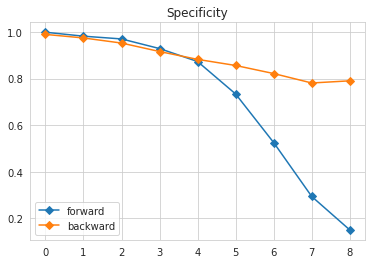

In [16]:
plt.plot(range(len(plot_data_forward)), plot_data_forward, label='forward', marker='D')
plt.plot(range(len(plot_data_backward)), plot_data_backward, label='backward', marker='D')
plt.xticks(range(len(plot_data_backward)))
plt.legend(loc='lower left')
plt.title(index_name[index])

plt.savefig('./figure/cut_experimet/' + index_name[index] + '.svg')
plt.show()

# Read motif extraction value

In [18]:
# This part value is calculated from motif_score.py
abs_negative = torch.load('./save_data/abs_negative.pt')
abs_positive = torch.load('./save_data/abs_positive.pt')
normal_negative = torch.load('./save_data/normal_negative.pt')
normal_positive = torch.load('./save_data/normal_positive.pt')

In [20]:
abs_negative[0]

[array([[6.18887134e-04, 2.18222849e-04, 2.60365196e-04, ...,
         1.26443012e-03, 9.98324715e-04, 7.02912919e-04],
        [6.13333192e-04, 8.29574186e-04, 2.06926372e-04, ...,
         4.79564536e-04, 1.17598427e-03, 1.39519805e-03],
        [7.64364377e-04, 1.87423220e-03, 1.34830223e-03, ...,
         1.60680944e-03, 1.76003203e-04, 1.56993046e-04],
        ...,
        [2.33652070e-04, 2.16384185e-03, 3.23423883e-03, ...,
         1.96139654e-03, 3.11932527e-04, 0.00000000e+00],
        [6.66460488e-04, 3.01348278e-03, 2.38444051e-03, ...,
         5.71076293e-04, 3.92110087e-05, 3.18787992e-04],
        [7.59650487e-04, 2.91583641e-03, 1.98023533e-03, ...,
         1.75025081e-03, 4.87611629e-04, 2.55038962e-04]]),
 'MSDPKYAYPYPAQGYYQGPPVMAPPQYPQYAAAPPPRRDTGFLEGCLAALCCCFLVDECCCDPSVLCIW']

In [21]:
normal_negative[0]

[array([[-6.18887134e-04, -2.18222849e-04, -2.60365196e-04, ...,
          1.26443012e-03, -9.98324715e-04, -7.02912919e-04],
        [-6.13333192e-04,  8.29574186e-04,  2.06926372e-04, ...,
         -4.79564536e-04, -1.17598427e-03, -1.39519805e-03],
        [-7.64364377e-04,  1.87423220e-03,  1.34830223e-03, ...,
          1.60680944e-03, -1.76003203e-04,  1.56993046e-04],
        ...,
        [ 2.33652070e-04,  2.16384185e-03,  3.23423883e-03, ...,
          1.96139654e-03, -3.11932527e-04,  0.00000000e+00],
        [ 6.66460488e-04,  3.01348278e-03,  2.38444051e-03, ...,
          5.71076293e-04,  3.92110087e-05, -3.18787992e-04],
        [-7.59650487e-04,  2.91583641e-03,  1.98023533e-03, ...,
          1.75025081e-03, -4.87611629e-04, -2.55038962e-04]]),
 'MSDPKYAYPYPAQGYYQGPPVMAPPQYPQYAAAPPPRRDTGFLEGCLAALCCCFLVDECCCDPSVLCIW']

In [22]:
aa_value_each_positive_sequence = []
# calculate each sequence aa value
# one sequence one matrix and sum each row
for sequence_data in normal_positive:
    matrix = sequence_data[0]
    matrix = matrix.sum(axis = 1)
    aa_value_each_positive_sequence.append(matrix.tolist())

In [ ]:
aa_value_each_positive_sequence

In [24]:
len(aa_value_each_positive_sequence[0])

22

In [25]:
aa_value_each_positive_sequence = np.array(aa_value_each_positive_sequence)

In [26]:
aa_value_each_positive_sequence = aa_value_each_positive_sequence.sum(axis = 0)

In [27]:
# min-max normalization
for i in range(len(aa_value_each_positive_sequence)):
    aa_value_positive = (aa_value_each_positive_sequence - np.min(aa_value_each_positive_sequence)) / (
            np.max(aa_value_each_positive_sequence) - np.min(aa_value_each_positive_sequence))

In [28]:
aa_value_positive

array([0.61341325, 0.        , 0.80083988, 0.51100244, 0.44327672,
       0.31135909, 0.55545901, 0.62886598, 0.66000094, 0.90001171,
       0.88919338, 0.45715619, 0.42991809, 1.        , 0.39723708,
       0.72301709, 0.59531079, 0.34469282, 0.77105833, 0.89105129,
       0.54065261, 0.90024545])

# AAC importance

## abs score

In [29]:
aa_value_each_negative_sequence = []
for sequence_data in abs_negative:
    matrix = sequence_data[0]
    matrix = matrix.sum(axis = 1)
#     matrix = matrix * -1
    matrix = matrix.tolist()
    aa_value_each_negative_sequence.append(matrix)

aa_value_each_negative_sequence = np.array(aa_value_each_negative_sequence).sum(axis=0)
for i in range(len(aa_value_each_negative_sequence)):
    aa_value_negative = (aa_value_each_negative_sequence - np.min(aa_value_each_negative_sequence)) / (
            np.max(aa_value_each_negative_sequence) - np.min(aa_value_each_negative_sequence))

In [30]:
aa_value_negative

array([0.00542541, 0.25427212, 0.86142672, 0.48178512, 0.31525356,
       0.39102288, 0.68118457, 0.03247537, 0.22068481, 0.51647206,
       0.59280853, 0.35921182, 0.46862913, 1.        , 0.56223226,
       0.19841128, 0.41665799, 0.        , 0.34134651, 0.75210516,
       0.14978289, 0.42182462])

In [31]:
aa_value_each_positive_sequence = []
for sequence_data in abs_positive:
    matrix = sequence_data[0]
    matrix = matrix.sum(axis = 1)
#     matrix = matrix * -1
    matrix = matrix.tolist()
    aa_value_each_positive_sequence.append(matrix)

aa_value_each_positive_sequence = np.array(aa_value_each_positive_sequence).sum(axis=0)
for i in range(len(aa_value_each_positive_sequence)):
    aa_value_positive = (aa_value_each_positive_sequence - np.min(aa_value_each_positive_sequence)) / (
            np.max(aa_value_each_positive_sequence) - np.min(aa_value_each_positive_sequence))

In [32]:
aa_value_positive

array([0.06293342, 1.        , 0.17470546, 0.4809075 , 0.38672042,
       0.62605873, 0.52157381, 0.04406377, 0.1238189 , 0.04710803,
       0.05869857, 0.34978812, 0.48853872, 0.09442132, 0.53829104,
       0.03523293, 0.15625359, 0.39586363, 0.0345353 , 0.13890255,
       0.21929251, 0.        ])

In [33]:
aa_list

['A',
 'R',
 'N',
 'D',
 'C',
 'Q',
 'E',
 'G',
 'H',
 'I',
 'L',
 'K',
 'M',
 'F',
 'P',
 'O',
 'S',
 'U',
 'T',
 'W',
 'Y',
 'V']

In [34]:
for i in range(len(aa_list)):
    print(aa_list[i], aa_value_negative[i], aa_value_positive[i])

A 0.005425407591668466 0.06293342079431044
R 0.25427212339276617 1.0
N 0.8614267153995826 0.17470545623679734
D 0.4817851156072437 0.48090749722694603
C 0.31525356239042734 0.3867204186940145
Q 0.3910228772115454 0.6260587263254561
E 0.681184569363906 0.5215738136722475
G 0.03247536759970966 0.04406376657087078
H 0.22068481306396648 0.12381889891241547
I 0.5164720622963737 0.04710802956921298
L 0.5928085345108676 0.058698574122246695
K 0.3592118232589767 0.3497881228942006
M 0.46862913005638257 0.4885387239813972
F 1.0 0.09442131604388333
P 0.562232257997464 0.5382910427473643
O 0.1984112843518947 0.03523292779390114
S 0.416657993675182 0.15625358513267606
U 0.0 0.395863626251657
T 0.34134650684888623 0.03453530281050002
W 0.7521051591979292 0.1389025482367224
Y 0.14978288549790975 0.21929251077053197
V 0.4218246245642581 0.0


## normal score

In [35]:
aa_value_each_negative_sequence = []
for sequence_data in normal_negative:
    matrix = sequence_data[0]
    matrix = matrix.sum(axis = 1)
    matrix = matrix * -1
    matrix = matrix.tolist()
    aa_value_each_negative_sequence.append(matrix)

aa_value_each_negative_sequence = np.array(aa_value_each_negative_sequence).sum(axis=0)
for i in range(len(aa_value_each_negative_sequence)):
    aa_value_negative_normal = (aa_value_each_negative_sequence - np.min(aa_value_each_negative_sequence)) / (
            np.max(aa_value_each_negative_sequence) - np.min(aa_value_each_negative_sequence))
    
aa_value_each_positive_sequence = []
for sequence_data in normal_positive:
    matrix = sequence_data[0]
    matrix = matrix.sum(axis = 1)
#     matrix = matrix * -1
    matrix = matrix.tolist()
    aa_value_each_positive_sequence.append(matrix)

aa_value_each_positive_sequence = np.array(aa_value_each_positive_sequence).sum(axis=0)
for i in range(len(aa_value_each_positive_sequence)):
    aa_value_positive_normal = (aa_value_each_positive_sequence - np.min(aa_value_each_positive_sequence)) / (
            np.max(aa_value_each_positive_sequence) - np.min(aa_value_each_positive_sequence))

In [36]:
print(aa_value_each_negative_sequence)
print(aa_value_each_positive_sequence)

[ -39.17953646  283.84768096 -418.39396217 -164.01246094  -72.08541387
  -36.27313136 -221.31451339 -113.51974702 -173.78745981 -335.62504515
 -345.71583321  -12.69557476   32.70921068 -531.64580832 -162.65851108
 -183.15313773 -189.62695699   68.47044646 -255.99470206 -377.87594957
 -115.17553924 -337.33401327]
[ -257.77370343 -1269.57139724    51.37813281  -426.69574474
  -538.40628555  -755.99851429  -353.3666302   -232.28511479
  -180.92939568   214.95762583   197.11327533  -515.51273018
  -560.44075446   379.88383778  -614.3466116    -76.98707975
  -287.6328985   -701.01602444     2.25479465   200.17781884
  -377.78911525   215.34316674]


In [37]:
for i in range(len(aa_list)):
    print(aa_list[i], aa_value_positive_normal[i], aa_value_negative_normal[i])

A 0.6134132484055105 0.6038874354421672
R 0.0 1.0
N 0.8008398785277753 0.1388752303283103
D 0.5110024416572928 0.45081089206618136
C 0.44327672322873174 0.5635365585208292
Q 0.31135909119889565 0.6074514186488135
E 0.5554590070617025 0.3805441723454294
G 0.628865979765871 0.5127276511613259
H 0.6600009375528062 0.4388242864122915
I 0.900011707834332 0.2403707273530698
L 0.8891933781704927 0.22799688477572602
K 0.45715618772407585 0.636363429485216
M 0.42991808915222 0.6920411093611061
F 1.0 0.0
P 0.3972370827194107 0.4524711749302525
O 0.7230170859900632 0.4273396111303407
S 0.595310789825634 0.41940108146123084
U 0.34469281780363137 0.7358933733577212
T 0.7710583257338524 0.33801754383101745
W 0.8910512906808263 0.18856049836250346
Y 0.5406526124834239 0.5106972337046901
V 0.9002454461631331 0.23827510286774797


In [38]:
aa_value_each_positive_sequence

array([ -257.77370343, -1269.57139724,    51.37813281,  -426.69574474,
        -538.40628555,  -755.99851429,  -353.3666302 ,  -232.28511479,
        -180.92939568,   214.95762583,   197.11327533,  -515.51273018,
        -560.44075446,   379.88383778,  -614.3466116 ,   -76.98707975,
        -287.6328985 ,  -701.01602444,     2.25479465,   200.17781884,
        -377.78911525,   215.34316674])

In [39]:
for i in range(len(aa_list)):
    aa_value_positive_normal[i] = aa_value_positive_normal[i] / (1-AAC_frequency_positive[aa_list[i]])
    aa_value_negative_normal[i] = aa_value_negative_normal[i] / (1-AAC_frequency_negative[aa_list[i]])
    print(aa_list[i], aa_value_positive_normal[i], aa_value_negative_normal[i])

A 0.6490587081446436 0.6499754056527105
R 0.0 1.0706939482515967
N 0.842062411388798 0.14265434440662536
D 0.5330343544876516 0.4662171866332038
C 0.4615302366226238 0.6017642713560303
Q 0.3210474282784051 0.656852733726984
E 0.5796604994613643 0.39539841751868876
G 0.6683216940109997 0.5591103209526452
H 0.677561262499439 0.4489893829299537
I 0.9634507324835051 0.24765068782427138
L 0.9916689385804873 0.24336281134163945
K 0.4852487078476743 0.6710411900366068
M 0.44274088168778875 0.7153377510750399
F 1.0615928373409718 0.0
P 0.41889380415454525 0.5000745587973888
O 0.7230170859900632 0.4273396111303407
S 0.6494937717550714 0.4573732798589316
U 0.34469281780363137 0.7358933733577212
T 0.8157079268951742 0.3506157320522915
W 0.9031140922218924 0.19088359682929254
Y 0.5579205009027783 0.5394420208629056
V 0.9669512024424253 0.2475570708042355


In [40]:
pre_aa_value_positive_normal = aa_value_positive_normal
pre_aa_value_negative_normal = aa_value_negative_normal
for i in range(len(aa_list)):
    pre_aa_value_positive_normal[i] = aa_value_each_positive_sequence[i] / (1-AAC_frequency_positive[aa_list[i]])
    pre_aa_value_negative_normal[i] = aa_value_each_negative_sequence[i] / (1-AAC_frequency_negative[aa_list[i]])
#     print(aa_list[i], aa_value_positive_normal[i], aa_value_negative_normal[i])
for i in range(len(pre_aa_value_positive_normal)):
    aa_value_positive_normal = (pre_aa_value_positive_normal - np.min(pre_aa_value_positive_normal)) / (
            np.max(pre_aa_value_positive_normal) - np.min(pre_aa_value_positive_normal))
for i in range(len(pre_aa_value_negative_normal)):
    aa_value_negative_normal = (pre_aa_value_negative_normal - np.min(pre_aa_value_negative_normal)) / (
            np.max(pre_aa_value_negative_normal) - np.min(pre_aa_value_negative_normal))

In [41]:
for i in range(len(aa_list)):
    print(aa_list[i], aa_value_positive_normal[i], aa_value_negative_normal[i])

A 0.6086267099558759 0.593194254452159
R 0.0 1.0
N 0.7978052381006997 0.13757646853347263
D 0.5088549302768549 0.44338504871004447
C 0.44199819925289 0.5522817436389013
Q 0.31524537505882955 0.5966578600799426
E 0.5530441712077397 0.37246300432647317
G 0.6236173928091803 0.4972543709541651
H 0.6589987401991186 0.4337514735550441
I 0.8997460837815342 0.2363023489036194
L 0.8937949573840621 0.20900175828637546
K 0.44974757285548556 0.6270265141493446
M 0.43239995681626914 0.6825053124607849
F 1.0 0.0
P 0.3914796732968282 0.4314496102921298
O 0.7219603983061169 0.42747454716983074
S 0.584856503097313 0.3996838847824561
U 0.36069464008857877 0.7232467252281026
T 0.7679110643624398 0.3306374040479122
W 0.8839868565153037 0.1931143333860588
Y 0.5408332570567111 0.4997590290471343
V 0.9004351163753339 0.2307954714893457


In [42]:
AAC_frequency_positive_value = []
AAC_frequency_negative_value = []
up_positive = []
up_negative = []

x_tick = []
for i in range(len(aa_list)):
    if aa_list[i] == 'O' or aa_list[i] == 'U':
        continue
    x_tick.append(aa_list[i])
    up_positive.append(aa_value_positive_normal[i])
    up_negative.append(aa_value_negative_normal[i])

    AAC_frequency_positive_value.append(AAC_frequency_positive[aa_list[i]]*-1)
    AAC_frequency_negative_value.append(AAC_frequency_negative[aa_list[i]]*-1)

In [44]:
print(x_tick)

['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']


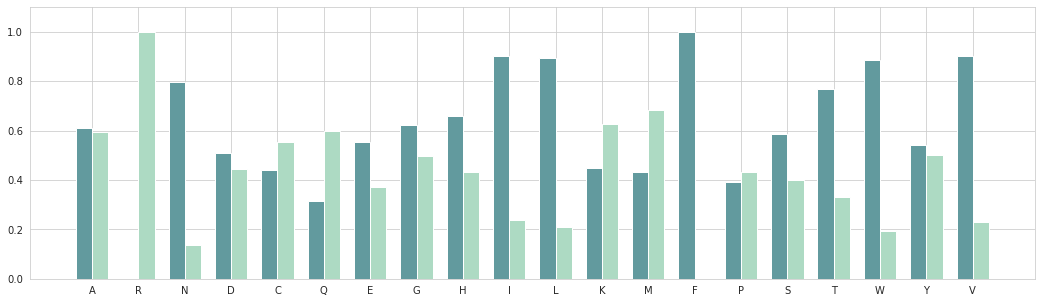

In [45]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(18,5))
ax=plt.axes()
n =len(x_tick)
X = np.arange(n)
bar_width = 0.35
# plt.figure
ax.bar(X - bar_width/2,up_positive,width=bar_width, color='#629a9e')
ax.bar(X + bar_width/2,up_negative,width=bar_width, color='#addac3')
# ax.bar(name,first,label='第一次语文成绩',width=bar_width,align='center',color='#00FA9A')
# ax.bar(np.arange(4)+bar_width,second,label='第二次语文成绩',width=bar_width,align='center',color='#EEE8AA')

# plt.bar(X,AAC_frequency_positive_value,facecolor='b',edgecolor='w')
ax.set_xticks(X)
ax.set_xticklabels(x_tick)
# plt.xlim((0,n))
plt.ylim(0,1.1)
# ax.xticks(X)
plt.savefig('./figure/aac_importance/model_weight.svg')
plt.show()

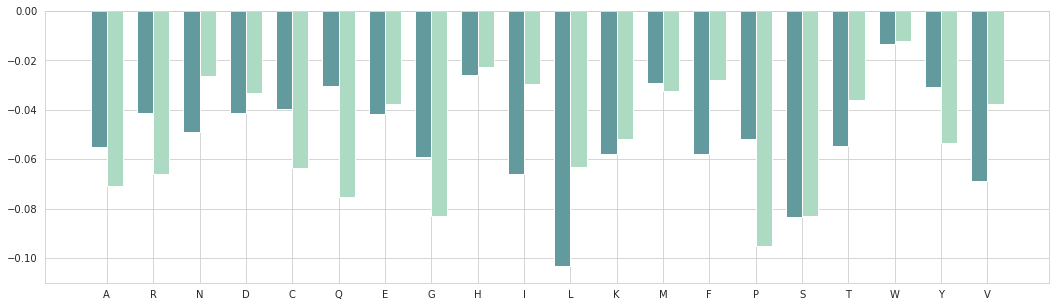

In [46]:
plt.figure(figsize=(18,5))
ax=plt.axes()
n =len(x_tick)
X = np.arange(n)
bar_width = 0.35
# plt.figure
ax.bar(X - bar_width/2,AAC_frequency_positive_value,width=bar_width, color='#629a9e')
ax.bar(X + bar_width/2,AAC_frequency_negative_value,width=bar_width, color='#addac3')

# plt.bar(X,AAC_frequency_positive_value,facecolor='b',edgecolor='w')
ax.set_xticks(X)
ax.set_xticklabels(x_tick)
# plt.xlim((0,n))
plt.ylim(-0.11,0)
plt.savefig('./figure/aac_importance/AAC_weight.svg')
# ax.xticks(X)
plt.show()

# Length importance Boxplot

## boxplot importance

In [47]:
cut_number = 25
sequences_position_value = [[] for i in range(cut_number)]

In [48]:
aa_value_each_negative_sequence = []
all_sequences = abs_positive + abs_negative
for sequence_data in all_sequences:
    matrix = sequence_data[0]
    result_matrix = matrix.sum(axis = 0)
    matrix = matrix * -1
    matrix = matrix.tolist()
    aa_value_each_negative_sequence.append(matrix)

    sequence_position_value = [0 for i in range(cut_number)]
    for i in range(len(result_matrix)):
        position = int(i / len(result_matrix) * cut_number)
        if position == cut_number:
            position = cut_number - 1
        sequence_position_value[position] += result_matrix[i].item()

    for i in range(len(sequences_position_value)):
        sequences_position_value[i].append(sequence_position_value[i])

In [49]:
def plot_box_now(data, keys):
    plt.figure(figsize=(12, 3))  # 画布
    ax=plt.axes()
    ax.grid(False)
    ax.boxplot(data,
                keys,  # 为箱线图添加标签，类似于图例的作用
                '',
                showmeans=True  # 是否显示均值，默认不显示
                )

    plt.show()

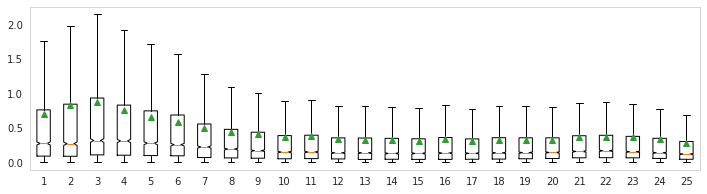

In [50]:
plot_box_now(sequences_position_value, [i for i in range(cut_number)])

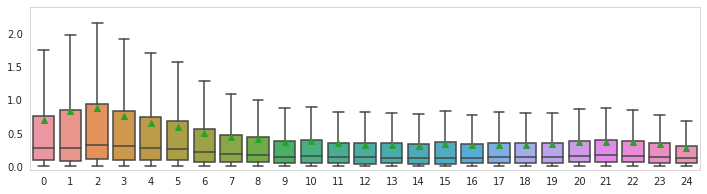

In [51]:
import seaborn as sns
plt.figure(figsize=(12, 3))  # 画布
ax=plt.axes()
ax.grid(False)
# sns.set_theme()
sns.boxplot(data=sequences_position_value, flierprops={'marker': ' '}, showmeans=True)
plt.ylim(-0.05,2.4)
plt.savefig('./figure/length_importance/acid_boxplot.svg')
plt.show()

## length importance correction

In [56]:
cut_number = 50
sequences_corretion_value = [[0 for j in aa_list] for i in range(cut_number)]
sequences_corretion_value = np.array(sequences_corretion_value)
print(sequences_corretion_value.shape)

all_sequences = abs_positive + abs_negative
for sequence_data in all_sequences[:5]:
    sequence = sequence_data[1]
    matrix = sequence_data[0]
#     result_matrix = matrix.sum(axis = 0)
#     matrix = matrix * -1
#     matrix = matrix.tolist()

    sequence_corretion_value = [[0 for j in aa_list] for i in range(cut_number)]
    for j in range(len(aa_list)):
        for i in range(len(sequence)):
            position = int(i / len(sequence) * cut_number)
            if position == cut_number:
                position = cut_number - 1
            sequence_corretion_value[position][j] += matrix[j][i].item()
    sequence_corretion_value = np.array(sequence_corretion_value)
#     print(sequence_corretion_value.shape)
#     print(sequences_corretion_value.shape)
#     print(sequences_corretion_value)
#     print(sequence_corretion_value)
    sequences_corretion_value = sequence_corretion_value + sequences_corretion_value
#     print(sequences_corretion_value)

(50, 22)


In [57]:
sequences_corretion_value

array([[0.11232132, 0.13260555, 0.12822717, ..., 0.126284  , 0.11254781,
        0.12535608],
       [0.07398802, 0.13660091, 0.08497822, ..., 0.15673572, 0.08595532,
        0.06873286],
       [0.07201469, 0.4106214 , 0.2119143 , ..., 0.06004453, 0.18489152,
        0.07789463],
       ...,
       [0.01726115, 0.03337413, 0.03721923, ..., 0.0524115 , 0.05140549,
        0.03872997],
       [0.03398424, 0.05509818, 0.02381116, ..., 0.03352344, 0.05415905,
        0.0335871 ],
       [0.02623779, 0.02973622, 0.01793379, ..., 0.03373224, 0.02355391,
        0.02332652]])

In [59]:
import pandas as pd
df_corretion = pd.DataFrame(columns=['position', 'acid','correlation'])

In [61]:
from sklearn import preprocessing
import numpy as np
min_max_scaler = preprocessing.MinMaxScaler()#默认为范围0~1，拷贝操作  # 其中默认的参数是 copy = True ，也就是生成新的数据，不改变原来的数据
# min_max_scaler1 = preprocessing.MinMaxScaler(feature_range = (1,3),copy = False)#范围改为1~3，对原数组操作
# min_max_scaler1 = preprocessing.MinMaxScaler(feature_range = (0,1),copy = False)#范围改为1~3，对原数组操作
# min_max_scaler1 = preprocessing.MinMaxScaler(feature_range = (0,1),copy = 0)#范围改为1~3，对原数组操作  # copy = 0 时，完全和 copy=False 时 得到的结果一样

# min_max_scaler1 = preprocessing.MinMaxScaler(feature_range = (0,1),copy = 1)#  copy =1 时 和 copy = True 时得到的结果一样， 其中copy=True 是系统默认的
sequences_corretion_value = min_max_scaler.fit_transform(sequences_corretion_value)


In [ ]:
# sequences_corretion_value = [[0 for j in aa_list] for i in range(cut_number)]

num = 0
for position_index in tqdm(range(len(sequences_corretion_value))):
    postion_value = sequences_corretion_value[position_index]
    for acid_index in tqdm(range(len(postion_value))):
        acid_value = aa_list[acid_index]
        if acid_value == 'U' or acid_value == 'O':
            continue
#         print(position_index)
#         print(acid_value)
#         print(postion_value[acid_index])
        df_corretion.loc[num] = [str(position_index), acid_value, postion_value[acid_index]]
        num += 1

In [63]:
df_corretion

,position,acid,correlation
0,0,A,0.659587
1,0,R,0.136540
2,0,N,0.424103
3,0,D,0.310087
4,0,C,0.652998
...,...,...,...
995,49,S,0.044145
996,49,T,0.038723
997,49,W,0.125293
998,49,Y,0.024396


<Figure size 648x288 with 0 Axes>

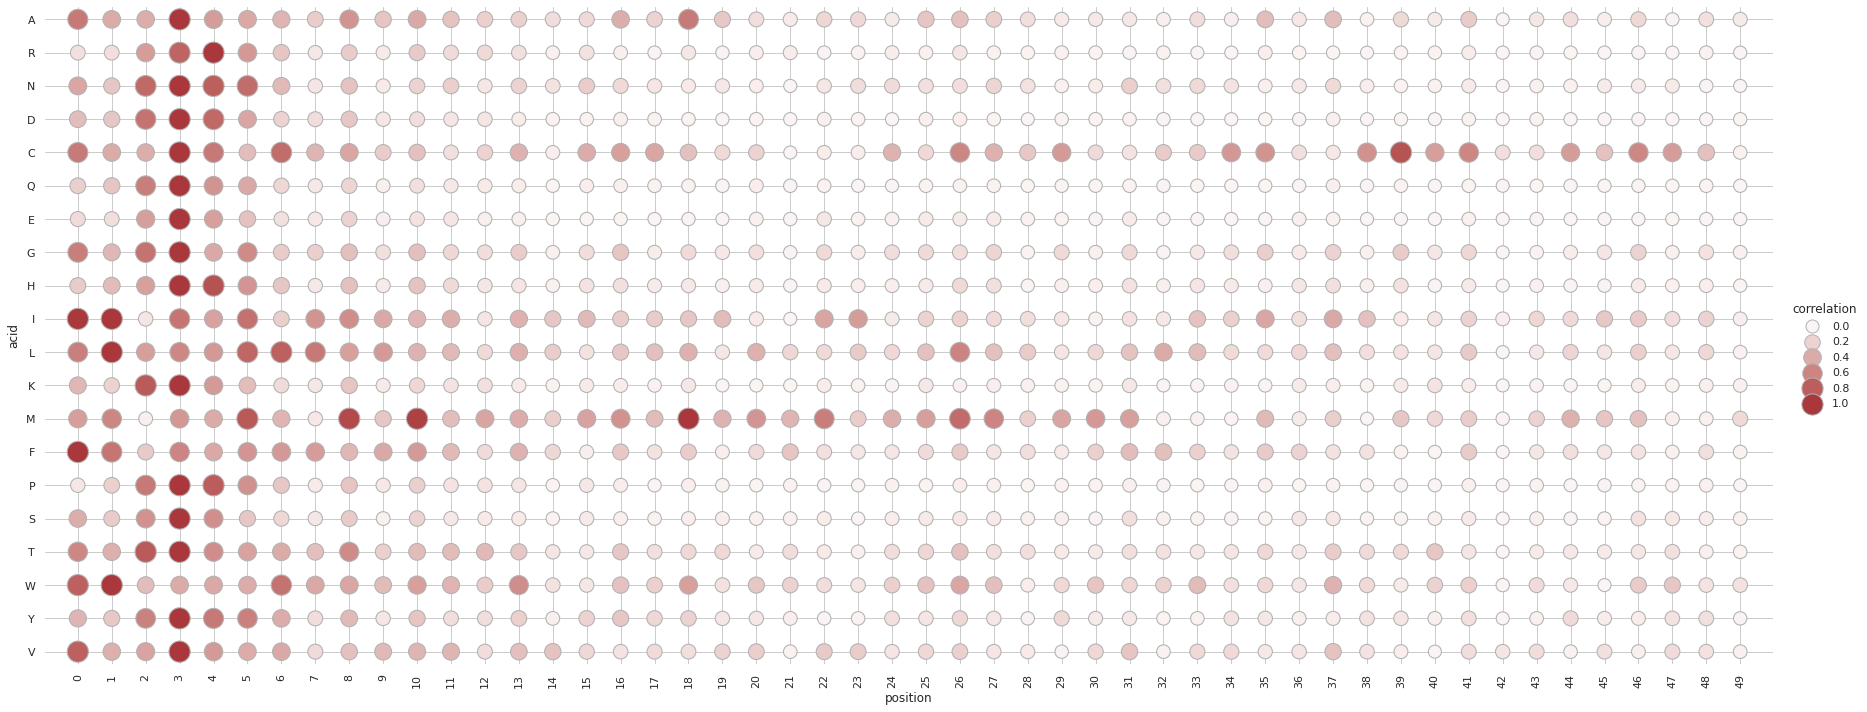

In [64]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(9,4))
g = sns.relplot(
    data=df_corretion,
    x="position", y="acid", hue="correlation", size="correlation",
    palette="vlag", 
    hue_norm=(-1, 1), 
    edgecolor=".7",
    height=10,
    aspect=2.5,
    sizes=(100, 450), 
    size_norm=(-.2, .8),
#     dashes=True
)

# Tweak the figure to finalize
# g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)
for artist in g.legend.legendHandles:
    artist.set_edgecolor(".7")
plt.savefig('./figure/length_importance/acid_postion.svg')
plt.show()

# motif extraction

In [501]:
# from motif_extraction_base import motif_analysis
# import motif_extraction_base

In [504]:
# !/usr/bin/python3
# --coding:utf-8--
# @File: motif_extraction_base.py
# @Author:junru jin
# @Time: 2022年12月 02日20
# @description:

import os
import pandas as pd
import numpy as np

def contiguous_regions(condition, len_thres=5):
    """
    Modified from and credit to: https://stackoverflow.com/a/4495197/3751373
    Finds contiguous True regions of the boolean array "condition". Returns
    a 2D array where the first column is the start index of the region and the
    second column is the end index.
    Arguments:
    condition -- custom conditions to filter/select high attention
            (list of boolean arrays)

    Keyword arguments:
    len_thres -- int, specified minimum length threshold for contiguous region
        (default 5)
    Returns:
    idx -- Index of contiguous regions in sequence
    """

    # Find the indicies of changes in "condition"
    d = np.diff(condition)
    idx, = d.nonzero()

    # We need to start things after the change in "condition". Therefore,
    # we'll shift the index by 1 to the right.
    idx += 1

    if condition[0]:
        # If the start of condition is True prepend a 0
        idx = np.r_[0, idx]

    if condition[-1]:
        # If the end of condition is True, append the length of the array
        idx = np.r_[idx, condition.size]  # Edit

    # Reshape the result into two columns
    idx.shape = (-1, 2)

    # eliminate those not satisfying length of threshold
    idx = idx[np.argwhere((idx[:, 1] - idx[:, 0]) >= len_thres).flatten()]
    return idx


def find_high_attention(score, min_len=5, **kwargs):
    """
    With an array of attention scores as input, finds contiguous high attention
    sub-regions indices having length greater than min_len.

    Arguments:
    score -- numpy array of attention scores for a sequence
    Keyword arguments:
    min_len -- int, specified minimum length threshold for contiguous region
        (default 5)
    **kwargs -- other input arguments:
        cond -- custom conditions to filter/select high attention
            (list of boolean arrays)

    Returns:
    motif_regions -- indices of high attention regions in sequence
    """

    cond1 = (score > np.mean(score))
    cond2 = (score > 10 * np.min(score))
    cond = [cond1, cond2]

    cond = list(map(all, zip(*cond)))

    if 'cond' in kwargs:  # if input custom conditions, use them
        cond = kwargs['cond']
        if any(isinstance(x, list) for x in cond):  # if input contains multiple conditions
            cond = list(map(all, zip(*cond)))

    cond = np.asarray(cond)

    # find important contiguous region with high attention
    motif_regions = contiguous_regions(cond, min_len)

    return motif_regions


def count_motif_instances(seqs, motifs, allow_multi_match=False):
    """
    Use Aho-Corasick algorithm for efficient multi-pattern matching
    between input sequences and motif patterns to obtain counts of instances.

    Arguments:
    seqs -- list, numpy array or pandas series of DNA sequences
    motifs -- list, numpy array or pandas series, a collection of motif patterns
        to be matched to seqs
    Keyword arguments:
    allow_multi_match -- bool, whether to allow for counting multiple matchs (default False)
    Returns:
    motif_count -- count of motif instances (int)

    """
    import ahocorasick
    from operator import itemgetter

    motif_count = {}

    A = ahocorasick.Automaton()
    for idx, key in enumerate(motifs):
        A.add_word(key, (idx, key))
        motif_count[key] = 0
    A.make_automaton()

    for seq in seqs:
        matches = sorted(map(itemgetter(1), A.iter(seq)))
        matched_seqs = []
        for match in matches:
            match_seq = match[1]
            assert match_seq in motifs
            if allow_multi_match:
                motif_count[match_seq] += 1
            else:  # for a particular seq, count only once if multiple matches were found
                if match_seq not in matched_seqs:
                    motif_count[match_seq] += 1
                    matched_seqs.append(match_seq)

    return motif_count


def motifs_hypergeom_test(pos_seqs, neg_seqs, motifs, p_adjust='fdr_bh', alpha=0.05, verbose=False,
                          allow_multi_match=False, **kwargs):
    """
    Perform hypergeometric test to find significantly enriched motifs in positive sequences.
    Returns a list of adjusted p-values.

    Arguments:
    pos_seqs -- list, numpy array or pandas series of positive DNA sequences
    neg_seqs -- list, numpy array or pandas series of negative DNA sequences
    motifs -- list, numpy array or pandas series, a collection of motif patterns
        to be matched to seqs
    Keyword arguments:
    p_adjust -- method used to correct for multiple testing problem. Options are same as
        statsmodels.stats.multitest (default 'fdr_bh')
    alpha -- cutoff FDR/p-value to declare statistical significance (default 0.05)
    verbose -- verbosity argument (default False)
    allow_multi_match -- bool, whether to allow for counting multiple matchs (default False)
    Returns:
    pvals -- a list of p-values.
    """
    from scipy.stats import hypergeom
    import statsmodels.stats.multitest as multi

    pvals = []
    N = len(pos_seqs) + len(neg_seqs)
    K = len(pos_seqs)
    motif_count_all = count_motif_instances(pos_seqs + neg_seqs, motifs, allow_multi_match=allow_multi_match)
    motif_count_pos = count_motif_instances(pos_seqs, motifs, allow_multi_match=allow_multi_match)

    for motif in motifs:
        n = motif_count_all[motif]
        x = motif_count_pos[motif]
        pval = hypergeom.sf(x - 1, N, K, n)
        if verbose:
            if pval < 1e-5:
                print("motif {}: N={}; K={}; n={}; x={}; p={}".format(motif, N, K, n, x, pval))
        #         pvals[motif] = pval
        pvals.append(pval)

    # adjust p-value
    if p_adjust is not None:
        pvals = list(multi.multipletests(pvals, alpha=alpha, method=p_adjust)[1])
    return pvals


def filter_motifs(pos_seqs, neg_seqs, motifs, cutoff=0.05, return_idx=False, **kwargs):
    """
    Wrapper function for returning the actual motifs that passed the hypergeometric test.

    Arguments:
    pos_seqs -- list, numpy array or pandas series of positive DNA sequences
    neg_seqs -- list, numpy array or pandas series of negative DNA sequences
    motifs -- list, numpy array or pandas series, a collection of motif patterns
        to be matched to seqs
    Keyword arguments:
    cutoff -- cutoff FDR/p-value to declare statistical significance. (default 0.05)
    return_idx -- whether the indices of the motifs are only returned. (default False)
    **kwargs -- other input arguments

    Returns:
    list of filtered motifs (or indices of the motifs)
    """
    pvals = motifs_hypergeom_test(pos_seqs, neg_seqs, motifs, **kwargs)
    if return_idx:
        return [i for i, pval in enumerate(pvals) if pval < cutoff]
    else:
        return [motifs[i] for i, pval in enumerate(pvals) if pval < cutoff]


def merge_motifs(motif_seqs, min_len=5, align_all_ties=True, **kwargs):
    """
    Function to merge similar motifs in input motif_seqs.

    First sort keys of input motif_seqs based on length. For each query motif with length
    guaranteed to >= key motif, perform pairwise alignment between them.

    If can be aligned, find out best alignment among all combinations, then adjust start
    and end position of high attention region based on left/right offsets calculated by
    alignment of the query and key motifs.

    If cannot be aligned with any existing key motifs, add to the new dict as new key motif.

    Returns a new dict containing merged motifs.

    Arguments:
    motif_seqs -- nested dict, with the following structure:
        {motif: {seq_idx: idx, atten_region_pos: (start, end)}}
        where seq_idx indicates indices of pos_seqs containing a motif, and
        atten_region_pos indicates where the high attention region is located.

    Keyword arguments:
    min_len -- int, specified minimum length threshold for contiguous region
        (default 5)

    align_all_ties -- bool, whether to keep all best alignments when ties encountered (default True)

    **kwargs -- other input arguments, may include:
        - cond: custom condition used to declare successful alignment.
            default is score > max of (min_len -1) and (1/2 times min length of two motifs aligned)

    Returns:
    merged_motif_seqs -- nested dict with same structure as `motif_seqs`
    """

    from Bio import Align

    ### TODO: modify algorithm to improve efficiency later
    aligner = Align.PairwiseAligner()
    aligner.internal_gap_score = -10000.0  # prohibit internal gaps

    merged_motif_seqs = {}
    for motif in sorted(motif_seqs, key=len):  # query motif
        if not merged_motif_seqs:  # if empty
            merged_motif_seqs[motif] = motif_seqs[motif]  # add first one
        else:  # not empty, then compare and see if can be merged
            # first create all alignment scores, to find out max
            alignments = []
            key_motifs = []
            for key_motif in merged_motif_seqs.keys():  # key motif
                if motif != key_motif:  # do not attempt to align to self
                    # first is query, second is key within new dict
                    # first is guaranteed to be length >= second after sorting keys
                    alignment = aligner.align(motif, key_motif)[0]

                    # condition to declare successful alignment
                    cond = max((min_len - 1), 0.5 * min(len(motif), len(key_motif)))

                    if 'cond' in kwargs:
                        cond = kwargs['cond']  # override

                    if alignment.score >= cond:  # exists key that can align
                        alignments.append(alignment)
                        key_motifs.append(key_motif)

            if alignments:  # if aligned, find out alignment with maximum score and proceed
                best_score = max(alignments, key=lambda alignment: alignment.score)
                best_idx = [i for i, score in enumerate(alignments) if score == best_score]

                if align_all_ties:
                    for i in best_idx:
                        alignment = alignments[i]
                        key_motif = key_motifs[i]

                        # calculate offset to be added/subtracted from atten_region_pos
                        left_offset = alignment.aligned[0][0][0] - alignment.aligned[1][0][0]  # always query - key
                        if (alignment.aligned[0][0][1] <= len(motif)) & \
                                (alignment.aligned[1][0][1] == len(key_motif)):  # inside
                            right_offset = len(motif) - alignment.aligned[0][0][1]
                        elif (alignment.aligned[0][0][1] == len(motif)) & \
                                (alignment.aligned[1][0][1] < len(key_motif)):  # left shift
                            right_offset = alignment.aligned[1][0][1] - len(key_motif)
                        elif (alignment.aligned[0][0][1] < len(motif)) & \
                                (alignment.aligned[1][0][1] == len(key_motif)):  # right shift
                            right_offset = len(motif) - alignment.aligned[0][0][1]

                        # add seq_idx back to new merged dict
                        merged_motif_seqs[key_motif]['seq_idx'].extend(motif_seqs[motif]['seq_idx'])

                        # calculate new atten_region_pos after adding/subtracting offset
                        new_atten_region_pos = [(pos[0] + left_offset, pos[1] - right_offset) \
                                                for pos in motif_seqs[motif]['atten_region_pos']]
                        merged_motif_seqs[key_motif]['atten_region_pos'].extend(new_atten_region_pos)

                else:
                    alignment = alignments[best_idx[0]]
                    key_motif = key_motifs[best_idx[0]]

                    # calculate offset to be added/subtracted from atten_region_pos
                    left_offset = alignment.aligned[0][0][0] - alignment.aligned[1][0][0]  # always query - key
                    if (alignment.aligned[0][0][1] <= len(motif)) & \
                            (alignment.aligned[1][0][1] == len(key_motif)):  # inside
                        right_offset = len(motif) - alignment.aligned[0][0][1]
                    elif (alignment.aligned[0][0][1] == len(motif)) & \
                            (alignment.aligned[1][0][1] < len(key_motif)):  # left shift
                        right_offset = alignment.aligned[1][0][1] - len(key_motif)
                    elif (alignment.aligned[0][0][1] < len(motif)) & \
                            (alignment.aligned[1][0][1] == len(key_motif)):  # right shift
                        right_offset = len(motif) - alignment.aligned[0][0][1]

                    # add seq_idx back to new merged dict
                    merged_motif_seqs[key_motif]['seq_idx'].extend(motif_seqs[motif]['seq_idx'])

                    # calculate new atten_region_pos after adding/subtracting offset
                    new_atten_region_pos = [(pos[0] + left_offset, pos[1] - right_offset) \
                                            for pos in motif_seqs[motif]['atten_region_pos']]
                    merged_motif_seqs[key_motif]['atten_region_pos'].extend(new_atten_region_pos)

            else:  # cannot align to anything, add to new dict as independent key
                merged_motif_seqs[motif] = motif_seqs[motif]  # add new one

    return merged_motif_seqs


def make_window(motif_seqs, pos_seqs, window_size=24):
    """
    Function to extract fixed, equal length sequences centered at high-attention motif instance.

    Returns new dict containing seqs with fixed window_size.

    Arguments:
    motif_seqs -- nested dict, with the following structure:
        {motif: {seq_idx: idx, atten_region_pos: (start, end)}}
        where seq_idx indicates indices of pos_seqs containing a motif, and
        atten_region_pos indicates where the high attention region is located.
    pos_seqs -- list, numpy array or pandas series of positive DNA sequences

    Keyword arguments:
    window_size -- int, specified window size to be final motif length
        (default 24)

    Returns:
    new_motif_seqs -- nested dict with same structure as `motif_seqs`s

    """
    new_motif_seqs = {}

    # extract fixed-length sequences based on window_size
    for motif, instances in motif_seqs.items():
        new_motif_seqs[motif] = {'seq_idx': [], 'atten_region_pos': [], 'seqs': []}
        for i, coord in enumerate(instances['atten_region_pos']):
            atten_len = coord[1] - coord[0]
            if (window_size - atten_len) % 2 == 0:  # even
                offset = (window_size - atten_len) / 2
                new_coord = (int(coord[0] - offset), int(coord[1] + offset))
                if (new_coord[0] >= 0) & (new_coord[1] < len(pos_seqs[instances['seq_idx'][i]])):
                    # append
                    new_motif_seqs[motif]['seq_idx'].append(instances['seq_idx'][i])
                    new_motif_seqs[motif]['atten_region_pos'].append((new_coord[0], new_coord[1]))
                    new_motif_seqs[motif]['seqs'].append(pos_seqs[instances['seq_idx'][i]][new_coord[0]:new_coord[1]])
            else:  # odd
                offset1 = (window_size - atten_len) // 2
                offset2 = (window_size - atten_len) // 2 + 1
                new_coord = (int(coord[0] - offset1), int(coord[1] + offset2))
                if (new_coord[0] >= 0) & (new_coord[1] < len(pos_seqs[instances['seq_idx'][i]])):
                    # append
                    new_motif_seqs[motif]['seq_idx'].append(instances['seq_idx'][i])
                    new_motif_seqs[motif]['atten_region_pos'].append((new_coord[0], new_coord[1]))
                    new_motif_seqs[motif]['seqs'].append(pos_seqs[instances['seq_idx'][i]][new_coord[0]:new_coord[1]])

    return new_motif_seqs


### make full pipeline
def motif_analysis(pos_seqs,
                   neg_seqs,
                   pos_atten_scores,
                   window_size=24,
                   min_len=4,
                   pval_cutoff=0.005,
                   min_n_motif=3,
                   align_all_ties=True,
                   save_file_dir=None,
                   **kwargs
                   ):
    """
    Wrapper function of full motif analysis tool based on DNABERT-viz.

    Arguments:
    pos_seqs -- list, numpy array or pandas series of positive DNA sequences
    neg_seqs -- list, numpy array or pandas series of negative DNA sequences
    pos_atten_scores -- numpy array of attention scores for postive DNA sequence

    Keyword arguments:
    window_size -- int, specified window size to be final motif length
        (default 24)
    min_len -- int, specified minimum length threshold for contiguous region
        (default 5)
    pval_cutoff -- float, cutoff FDR/p-value to declare statistical significance. (default 0.005)
    min_n_motif -- int, minimum instance inside motif to be filtered (default 3)
    align_all_ties -- bool, whether to keep all best alignments when ties encountered (default True)
    save_file_dir -- str, path to save outputs (default None)
    **kwargs -- other input arguments, may include:
        - verbose: bool, verbosity controller
        - atten_cond: custom conditions to filter/select high attention
            (list of boolean arrays)
        - return_idx: whether the indices of the motifs are only returned.
        - align_cond: custom condition used to declare successful alignment.
            default is score > max of (min_len -1) and (1/2 times min length of two motifs aligned)

    Returns:
    merged_motif_seqs -- nested dict, with the following structure:
        {motif: {seq_idx: idx, atten_region_pos: (start, end)}}
        where seq_idx indicates indices of pos_seqs containing a motif, and
        atten_region_pos indicates where the high attention region is located.

    """
    from Bio import motifs
    from Bio.Seq import Seq

    verbose = False
    if 'verbose' in kwargs:
        verbose = kwargs['verbose']

    if verbose:
        print("*** Begin motif analysis ***")
    pos_seqs = list(pos_seqs)
    neg_seqs = list(neg_seqs)

    if verbose:
        print("* pos_seqs: {}; neg_seqs: {}".format(len(pos_seqs), len(neg_seqs)))

    assert len(pos_seqs) == len(pos_atten_scores)

    max_seq_len = len(max(pos_seqs, key=len))
    motif_seqs = {}

    ## find the motif regions
    if verbose:
        print("* Finding high attention motif regions")
    for i, score in enumerate(pos_atten_scores):
        seq_len = len(pos_seqs[i])
        score = score[0:seq_len]

        # handle kwargs
        if 'atten_cond' in kwargs:
            motif_regions = find_high_attention(score, min_len=min_len, cond=kwargs['atten_cond'])
        else:
            motif_regions = find_high_attention(score, min_len=min_len)

        for motif_idx in motif_regions:
            seq = pos_seqs[i][motif_idx[0]:motif_idx[1]]
            if seq not in motif_seqs:
                motif_seqs[seq] = {'seq_idx': [i], 'atten_region_pos': [(motif_idx[0], motif_idx[1])]}
            else:
                motif_seqs[seq]['seq_idx'].append(i)
                motif_seqs[seq]['atten_region_pos'].append((motif_idx[0], motif_idx[1]))

    # filter motifs
    return_idx = False
    if 'return_idx' in kwargs:
        return_idx = kwargs['return_idx']
        kwargs.pop('return_idx')

    if verbose:
        print("* Filtering motifs by hypergeometric test")
    motifs_to_keep = filter_motifs(pos_seqs,
                                   neg_seqs,
                                   list(motif_seqs.keys()),
                                   cutoff=pval_cutoff,
                                   return_idx=return_idx,
                                   **kwargs)

    motif_seqs = {k: motif_seqs[k] for k in motifs_to_keep}

    # merge motifs
    if verbose:
        print("* Merging similar motif instances")
    if 'align_cond' in kwargs:
        merged_motif_seqs = merge_motifs(motif_seqs, min_len=min_len,
                                         align_all_ties=align_all_ties,
                                         cond=kwargs['align_cond'])
    else:
        merged_motif_seqs = merge_motifs(motif_seqs, min_len=min_len,
                                         align_all_ties=align_all_ties)

    # make fixed-length window sequences
    if verbose:
        print("* Making fixed_length window = {}".format(window_size))
    merged_motif_seqs = make_window(merged_motif_seqs, pos_seqs, window_size=window_size)

    # remove motifs with only few instances
    if verbose:
        print("* Removing motifs with less than {} instances".format(min_n_motif))
    merged_motif_seqs = {k: coords for k, coords in merged_motif_seqs.items() if len(coords['seq_idx']) >= min_n_motif}

    if save_file_dir is not None:
        if verbose:
            print("* Saving outputs to directory")
        os.makedirs(save_file_dir, exist_ok=True)
        for motif, instances in merged_motif_seqs.items():
            # saving to files
            with open(save_file_dir + '/motif_{}_{}.txt'.format(motif, len(instances['seq_idx'])), 'w') as f:
                for seq in instances['seqs']:
                    f.write(seq + '\n')
            # make weblogo
            seqs = [Seq(v) for i, v in enumerate(instances['seqs'])]
            # m = motifs.create(seqs)
            # m.weblogo(save_file_dir + "/motif_{}_{}_weblogo.png".format(motif, len(instances['seq_idx'])),
            #           format='png_print',
            #           show_fineprint=False, show_ends=False, color_scheme='color_classic')

    return merged_motif_seqs

In [480]:
pos_atten_scores = []
for sequence_data in abs_positive:
    matrix = sequence_data[0]
    sequence = sequence_data[1]
    matrix_results = matrix.sum(axis = 0)
    assert len(matrix_results) == len(sequence)
#     matrix_results = min_max_scaler.fit_transform(matrix_results)
    for i in range(len(matrix_results)):
        matrix_results = (matrix_results - np.min(matrix_results)) / (
                np.max(matrix_results) - np.min(matrix_results))
    pos_atten_scores.append(matrix_results.tolist())

In [526]:
motif_analysis(positive_sequences, 
             negative_sequences, 
             pos_atten_scores,
             window_size=7,
             min_len=4,
             pval_cutoff=0.5,
             min_n_motif=2,
             align_all_ties=False,
             save_file_dir='./pattern_figure/minLen4',
             verbose=False,
             return_idx=False
             )


{'LLVF': {'seq_idx': [49, 100, 131, 315],
  'atten_region_pos': [(44, 51), (21, 28), (15, 22), (20, 27)],
  'seqs': ['WLLVFKS', 'SLFVFAG', 'SLFVFFT', 'GLLVTSQ']},
 'ILSL': {'seq_idx': [171,
   178,
   516,
   1062,
   1054,
   484,
   550,
   600,
   696,
   809,
   791,
   1056],
  'atten_region_pos': [(22, 29),
   (16, 23),
   (9, 16),
   (10, 17),
   (32, 39),
   (12, 19),
   (20, 27),
   (12, 19),
   (5, 12),
   (12, 19),
   (10, 17),
   (10, 17)],
  'seqs': ['VILSLAC',
   'HLLSLLF',
   'VILFLRP',
   'TILFLSL',
   'LSLSLSL',
   'LSLSLSL',
   'LSLSLSL',
   'LSLSLSL',
   'LSLSLSL',
   'LSLSLSL',
   'LILFLSI',
   'LSLSLSL']},
 'FLLG': {'seq_idx': [185, 1121],
  'atten_region_pos': [(22, 29), (14, 21)],
  'seqs': ['SFLLGAY', 'LFLLHVI']},
 'LFIV': {'seq_idx': [219, 371, 495, 1062],
  'atten_region_pos': [(15, 22), (15, 22), (15, 22), (15, 22)],
  'seqs': ['SLFIVVI', 'SLFIVAM', 'SLFLVVT', 'SLFLVAA']},
 'LVLA': {'seq_idx': [232, 330, 471],
  'atten_region_pos': [(16, 23), (16, 23), (16, 2